<a href="https://colab.research.google.com/github/mostlydipo/Tensorflow-Projects--Advanced/blob/main/Neural_Network_SMS_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [3]:
import nltk
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [5]:
train_file_path = "train-data.tsv" # Reading train data tsv file
td_train= pd.read_table(train_file_path, sep='\t')
test_file_path = "valid-data.tsv" # Reading test data tsv file
td_test =  pd.read_table(test_file_path, sep='\t')

In [6]:
 # Converting datasets from tsv to csv
td_train.to_csv("train-data.csv", index = False)
td_test.to_csv("valid-data.csv", index = False)

In [7]:
td_train.head() # Structure of our data set in row and column
                # Training data

,ham,"ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it."
0,ham,you can never do nothing
1,ham,"now u sound like manky scouse boy steve,like! ..."
2,ham,mum say we wan to go then go... then she can s...
3,ham,never y lei... i v lazy... got wat? dat day ü ...
4,ham,in xam hall boy asked girl tell me the startin...


In [8]:
td_test.head()  # Structure of our data set in row and column
                # Testing data

,ham,i am in hospital da. . i will return home in evening
0,ham,"not much, just some textin'. how bout you?"
1,ham,i probably won't eat at all today. i think i'm...
2,ham,don‘t give a flying monkeys wot they think and...
3,ham,who are you seeing?
4,ham,your opinion about me? 1. over 2. jada 3. kusr...


In [9]:
td_train.info() # More useful information about our dataset for better understanding
                # training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 2 columns):
 #   Column                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                              --------------  ----- 
 0   ham                                                                                                                                                 4178 non-null   object
 1   ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.  4178 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [10]:
td_test.info() # More useful information about our dataset for better understanding
              # Testing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 2 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   ham                                                   1391 non-null   object
 1   i am in hospital da. . i will return home in evening  1391 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


In [11]:
td_train.isin(['spam']).any() # Confirm if spam exists in our dataset

ham                                                                                                                                                    True
ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.    False
dtype: bool

In [12]:
td_train['ham'] = td_train['ham'].map({'ham' : 0, 'spam': 1}) # Replace strings with integers
td_test['ham'] = td_test['ham'].map({'ham' : 0, 'spam': 1})   # Replace spam and ham with zeros and ones

In [13]:
td_train.rename(columns={'ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.':'message'}, inplace=True) # Rename cateogrical column
td_test.rename(columns={'i am in hospital da. . i will return home in evening':'message'}, inplace=True)

In [14]:
td_train.rename(columns={'ham':'folder'}, inplace = True) # Rename numeric column
td_test.rename(columns={'ham':'folder'}, inplace = True)

In [15]:
td_train # Confirm our newly formatted headings and values
        # Changing ham to Zeros and spam to ones
        # change categorical coulumn name to 'message' and numeric column to 'folder'
        # Training data

,folder,message
0,0,you can never do nothing
1,0,"now u sound like manky scouse boy steve,like! ..."
2,0,mum say we wan to go then go... then she can s...
3,0,never y lei... i v lazy... got wat? dat day ü ...
4,0,in xam hall boy asked girl tell me the startin...
...,...,...
4173,0,just woke up. yeesh its late. but i didn't fal...
4174,0,what do u reckon as need 2 arrange transport i...
4175,1,free entry into our £250 weekly competition ju...
4176,1,-pls stop bootydelious (32/f) is inviting you ...


In [16]:
td_test # Confirm our newly formatted headings and values
        # Changing ham to Zeros and spam to ones
        # change categorical coulumn name to 'message' and numeric column to 'folder'
        # Testing data

,folder,message
0,0,"not much, just some textin'. how bout you?"
1,0,i probably won't eat at all today. i think i'm...
2,0,don‘t give a flying monkeys wot they think and...
3,0,who are you seeing?
4,0,your opinion about me? 1. over 2. jada 3. kusr...
...,...,...
1386,0,true dear..i sat to pray evening and felt so.s...
1387,0,"what will we do in the shower, baby?"
1388,0,where are you ? what are you doing ? are yuou ...
1389,1,ur cash-balance is currently 500 pounds - to m...


In [17]:
y_train = td_train['folder'].astype('category').cat.codes # Trainig and Testing labels
y_test  = td_test['folder'].astype('category').cat.code   # Pop out our numerical values and store in own variables

Text(0.5, 1.0, 'Number of ham and spam texts')

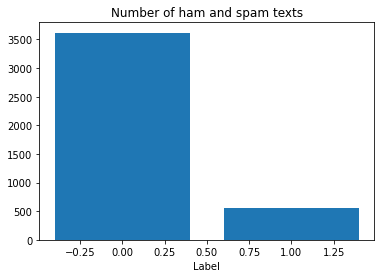

In [18]:
bar = td_train['folder'].value_counts() # Visualization of our distribution

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam texts')

**Text processing**

In [19]:
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


179

In [20]:
lemmatizer = WordNetLemmatizer() # Cleaning texts and removing symbols

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [21]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [22]:
X_train = td_train['message'].apply(lambda x: clean_txt(x)) # New look of text
X_train[:5]

0                                        never nothing
1    u sound like manky scouse boy steve like trave...
2    mum say wan go go shun bian watch da glass exh...
3    never lei v lazy got wat dat day ü send da url...
4    xam hall boy asked girl tell starting term dis...
Name: message, dtype: object

**Vectorize**

In [23]:
# Retain 1000 frequently occurring words
max_words = 1000

# Stop after seeing 500 words in each document
max_len = 500

In [24]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [28]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:3]

[[195, 252],
 [1, 309, 15, 219, 15, 42, 310, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 42]]

In [29]:
from keras.utils import pad_sequences  # Keras,preprovcssing does not work, hence this.

In [31]:
# Make all rows of equal length
sequences_matrix =pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  42],
       [  0,   0,   0, ..., 124,  70,  24],
       [  0,   0,   0, ...,  32, 137,  90]], dtype=int32)

**Model**

In [32]:
i=tf.keras.layers.Input(shape=[max_len])
x=tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x=tf.keras.layers.LSTM(64)(x)

x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable p

In [60]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=10,
              validation_split=0.2, validation_steps=30,

)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9847

27/27 [==============================] - 29s 1s/step - loss: 0.0895 - accuracy: 0.9847 - val_loss: 0.1141 - val_accuracy: 0.9904
Epoch 2/10
27/27 [==============================] - 26s 946ms/step - loss: 0.0706 - accuracy: 0.9889
Epoch 3/10
27/27 [==============================] - 25s 909ms/step - loss: 0.0648 - accuracy: 0.9934
Epoch 4/10
27/27 [==============================] - 25s 920ms/step - loss: 0.0565 - accuracy: 0.9946
Epoch 5/10
27/27 [==============================] - 22s 831ms/step - loss: 0.0554 - accuracy: 0.9943
Epoch 6/10
27/27 [==============================] - 25s 909ms/step - loss: 0.0533 - accuracy: 0.9961
Epoch 7/10
27/27 [==============================] - 22s 796ms/step - loss: 0.0535 - accuracy: 0.9952
Epoch 8/10
27/27 [==============================] - 26s 962ms/step - loss: 0.0528 - accuracy: 0.9961
Epoch 9/10
27/27 [==============================] - 23s 838ms/step - loss: 0.0518 - accuracy: 0.9964
Epoch 10/10
27/27 [==============================] - 22s 801ms/

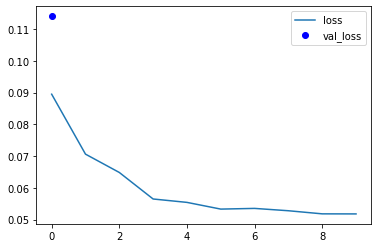

In [61]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], 'bo', label='val_loss')
plt.legend()


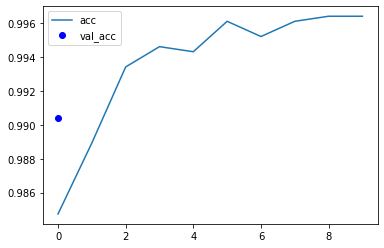

In [62]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],'bo',label='val_acc')
plt.legend()

In [63]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return pad_sequences(x, maxlen=max_len)

In [64]:
m = model.evaluate(preprocessing(td_test['message']), y_test)

44/44 [==============================] - 4s 97ms/step - loss: 0.1241 - accuracy: 0.9871


In [65]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(m[0], m[1]))

Loss: 0.124, Accuracy: 0.987


**Project check**

In [66]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 58ms/step
(0.0, 'ham')


In [67]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 55ms/step
You passed the challenge. Great job!
